In [1]:
import my_test
import pandas as pd

In [2]:
### Loading all preprocessed data
my_test.run()

/home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(0.4211459954400896, 0.40186915887850466, 0.3866006945909624, None)


### Investigating the data.pkl

A quick investigation of the `data.pkl` dataset

In [3]:
dataset = pd.read_pickle('data.pkl')
dataset.head()

,body_basic,label
0,Fly fishing is an angling method that uses a ...,fly_fishing
1,Simms GORE TEX ExStream Cap 89 95 Simms Dockwe...,fly_fishing
2,Article NPS Photo Neal Herbert The thick yello...,fly_fishing
3,Fly Fishing is a technique for catching fish w...,fly_fishing
4,11 Tips to Help You Sell a Boat Online Fishin...,fly_fishing


In [4]:
dataset.tail()

,body_basic,label
232,We use cookies to give you a better experience...,machine_learning
233,This post is part one in a three part series o...,machine_learning
234,A leading edge research firm focused on digita...,machine_learning
235,Explore Northeastern s first international cam...,machine_learning
236,At this time the University of Reston is not a...,machine_learning


The labels seems to have be stacked on each other

In [5]:
label_mapper = {
    key: value 
    for key, value in zip(
        range(3), 
        list(dataset.label.unique())
    )
}

label_mapper_inverse = {
    label_mapper[label]: label 
    for label in label_mapper
}

label_mapper, label_mapper_inverse

({0: 'fly_fishing', 1: 'ice_hockey', 2: 'machine_learning'},
 {'fly_fishing': 0, 'ice_hockey': 1, 'machine_learning': 2})

The label_mapper and label_mapper_inverse would be useful at the end of the program

In [5]:
print(f"Dataset length: {len(dataset)}")
print("-"*40)
print(f"Dataset fly_fishing length: {len(dataset[dataset.label == 'fly_fishing'])}")
print(f"Dataset ice_hockey length: {len(dataset[dataset.label == 'ice_hockey'])}")
print(f"Dataset machine_learning length: {len(dataset[dataset.label == 'machine_learning'])}")

Dataset length: 237
----------------------------------------
Dataset fly_fishing length: 86
Dataset ice_hockey length: 70
Dataset machine_learning length: 81


In [6]:
from tools import plot_word_frequency

Most common words in the dataset

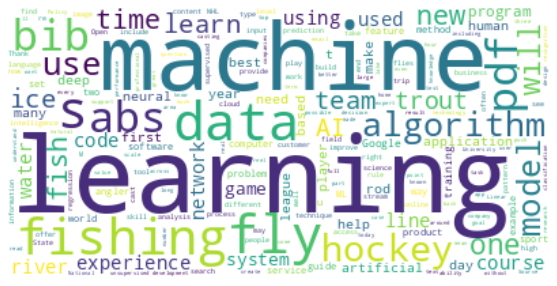

In [7]:
plot_word_frequency(dataset, column='body_basic')

Let's see how common this word are in the context of their labels

#### For `fly_fishing`

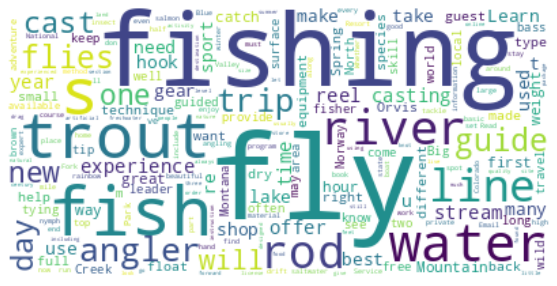

In [8]:
plot_word_frequency(dataset, column='body_basic', col_filter='fly_fishing', use_col_filter='label')

#### For `ice_hockey`

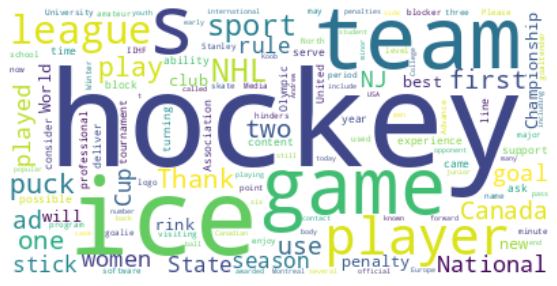

In [9]:
plot_word_frequency(dataset, column='body_basic', col_filter='ice_hockey', use_col_filter='label')

#### For `machine_learning`

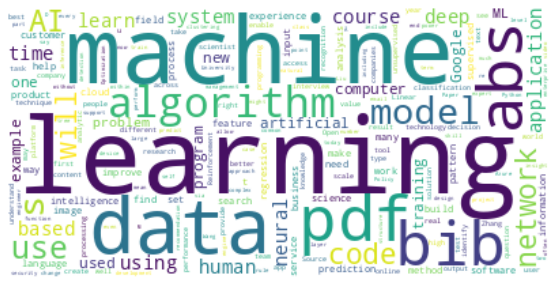

In [10]:
plot_word_frequency(dataset, column='body_basic', col_filter='machine_learning', use_col_filter='label')

### Investigating the previous work

A quick investigation of the previous work done

In [11]:
count_vectorizer = pd.read_pickle('vec.pkl')
random_forest_classifier = pd.read_pickle('rf.pkl')
pca = pd.read_pickle('pca.pkl')

In [12]:
body_basic_transformed = pca.transform(count_vectorizer.transform(dataset.body_basic).toarray())
body_basic_transformed.shape

/home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


(237, 1)

In [13]:
prediction_1 = random_forest_classifier.predict(body_basic_transformed)
prediction_1[:10]

array(['machine_learning', 'fly_fishing', 'ice_hockey', 'fly_fishing',
       'machine_learning', 'ice_hockey', 'fly_fishing', 'fly_fishing',
       'machine_learning', 'machine_learning'], dtype=object)

We can already tell the model is performing poorly; The first 10 prediction should all be `fly_fishing`.

In [14]:
from tools import compare_conf_mx, scorer
from sklearn.metrics import confusion_matrix

In [15]:
dataset_label = dataset.label.to_numpy()

In [16]:
scorer(dataset_label, prediction_1)

Accuracy score 0.459915611814346

Precision score 0.4749092856263865

Recall score 0.4753195794539464



The scores here(accuracy, precision and recall) are for the entire dataset, as opposed to the initial scores of ~40% for the test dataset

In [17]:
conf_mx_1 = confusion_matrix(dataset_label, prediction_1)
conf_mx_1

array([[26, 38, 22],
       [11, 51,  8],
       [16, 33, 32]])

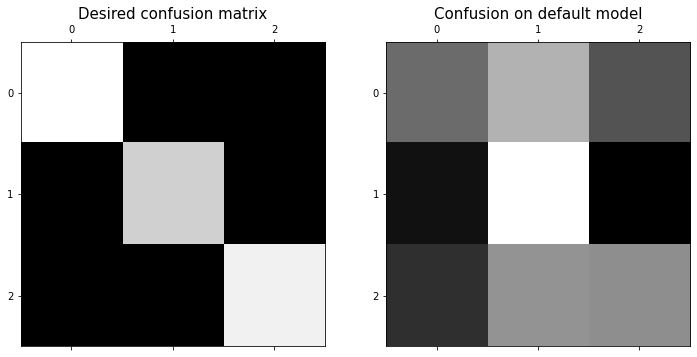

In [18]:
perfect_conf_mx = confusion_matrix(dataset_label, dataset_label)
mx_s = [perfect_conf_mx, conf_mx_1]
titles = [
    "Desired confusion matrix",
    "Confusion on default model"
]

compare_conf_mx((1,2), mx_s=mx_s, titles=titles)

The initial model was able to predict the actual values of `ice_hockey ` best, while distinguishing it from the others during prediction. The same can't be said for the other two classes, as the model struggles to understand their relationship.

Given this model performance, I would adjust my approach a little.

1. I would make use of TfIdfVectorizer/transformer embeddings instead of a CountVectorizer, because a TfIdfVectorizer takes note of the impact of the frequency of a word with respect to the document. Transformer embeddings capture the contextual information in a corpus based on the popular attention models
2. For the PCA I would set the number of components to 0.9 to ensure that reduced dimensionality does not have major impact on the prediction
3. I would make use of random forest classifier, fine-tuning it to make it more adequate.

### Data Splitting

Separating a test set from the training set.

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
target = dataset.label
data = dataset.drop('label', axis=1)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=.26, shuffle=True, 
    stratify=target, random_state=42
)

y_train.shape, y_test.shape

((175,), (62,))

### 1. Applying the TfIdfVectorizer

I will start by vectorizing the word corpus

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
vectorizer = TfidfVectorizer()

In [24]:
vectorizer.fit(X_train.body_basic.to_list())

TfidfVectorizer()

In [25]:
X_train_trans = vectorizer.transform(X_train.body_basic.to_list())

In [27]:
X_train_trans.shape

(175, 11506)

### 2. Applying the PCA

I would now apply the PCA to adjust the dimensions

In [28]:
from sklearn.decomposition import PCA

In [29]:
pca = PCA(n_components=.9)

In [30]:
pca.fit(X_train_trans.toarray())

PCA(n_components=0.9)

In [31]:
X_train_trans = pca.transform(X_train_trans.toarray())

In [32]:
X_train_trans.shape

(175, 111)

Much better

### 3. Apply changes to random forest classifier

Now I would apply my new data to a random forest classifier, with it's default parameters using cross validation

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [34]:
random_classifier = RandomForestClassifier(random_state=42)

Since the classes are almost equally balanced, I would rely on the accuracy

In [35]:
scores = cross_val_score(random_classifier, X_train_trans, y_train, scoring='accuracy', cv=5)
scores

array([0.82857143, 0.77142857, 0.88571429, 0.91428571, 0.82857143])

In [36]:
scores.mean()

0.8457142857142858

The model performs by average 84.57%, which is about 38.58% better than our initial model.

I would create a function to transform new data for prediction

In [37]:
def transform_data(data):
    # Vectorize data
    data = vectorizer.transform(data.body_basic.to_list())
    
    # Decompose data
    data = pca.transform(data.toarray())
    
    return data

In [38]:
random_classifier.fit(X_train_trans, y_train)

RandomForestClassifier(random_state=42)

In [39]:
test_data = transform_data(X_test)

In [40]:
prediction_2 = random_classifier.predict(test_data)

In [41]:
prediction_2[:10]

array(['machine_learning', 'fly_fishing', 'machine_learning',
       'ice_hockey', 'fly_fishing', 'machine_learning',
       'machine_learning', 'fly_fishing', 'fly_fishing', 'ice_hockey'],
      dtype=object)

In [42]:
scorer(y_test, prediction_2)

Accuracy score 0.8870967741935484

Precision score 0.8860408597250702

Recall score 0.8877386703473659



In [43]:
from sklearn.metrics import classification_report

In [44]:
print(classification_report(y_test, prediction_2))

                  precision    recall  f1-score   support

     fly_fishing       0.95      0.87      0.91        23
      ice_hockey       0.84      0.89      0.86        18
machine_learning       0.86      0.90      0.88        21

        accuracy                           0.89        62
       macro avg       0.89      0.89      0.89        62
    weighted avg       0.89      0.89      0.89        62



## 2. Use of HuggingFace Transformer embeddings

In [45]:
df = dataset.copy()

In [46]:
df.head(2)

,body_basic,label
0,Fly fishing is an angling method that uses a ...,fly_fishing
1,Simms GORE TEX ExStream Cap 89 95 Simms Dockwe...,fly_fishing


In [47]:
from transformer_embeddings import merge_emb

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
df_embed = merge_emb(df)

In [49]:
df_embed.head(2)

,label,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_374,emb_375,emb_376,emb_377,emb_378,emb_379,emb_380,emb_381,emb_382,emb_383
0,fly_fishing,-0.128435,0.132155,0.143896,-0.161589,0.022448,-0.135859,0.382666,-0.080613,-0.360659,...,0.212680,0.291347,0.002251,0.07050,0.033455,-0.046300,-0.533279,-0.117479,-0.166297,0.830841
1,fly_fishing,-0.413259,0.254326,0.050661,-0.240573,0.310878,-0.045872,0.278567,0.143699,-0.457046,...,-0.421683,0.131901,-0.176795,0.33245,-0.080846,0.158363,-0.647330,-0.716656,-0.320095,0.069770


In [50]:
df_embed.loc[:,'label'] = df_embed['label'].map({'fly_fishing': 0, 'ice_hockey': 1, 'machine_learning': 2})

In [51]:
df_embed.shape

(237, 385)

In [52]:
target = df_embed.label
data = df_embed.drop('label', axis=1)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=.26, shuffle=True, 
    stratify=target, random_state=42
)

y_train.shape, y_test.shape

((175,), (62,))

In [54]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [55]:
classifiers = [
               KNeighborsClassifier(),
               DecisionTreeClassifier(),
               RandomForestClassifier(),
               AdaBoostClassifier(),
               GradientBoostingClassifier(),
               LogisticRegression()
]

In [56]:
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(classifier)
    print("model score: %.3f" % classifier.score(X_test, y_test))
    print('confusion matrix')
    print(metrics.confusion_matrix(y_test, y_pred))
    print('classification report')
    print(metrics.classification_report(y_test, y_pred))
    print('Accuracy : %f' % (metrics.accuracy_score(y_test, y_pred)))

KNeighborsClassifier()
model score: 0.968
confusion matrix
[[22  0  1]
 [ 0 17  1]
 [ 0  0 21]]
classification report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        23
           1       1.00      0.94      0.97        18
           2       0.91      1.00      0.95        21

    accuracy                           0.97        62
   macro avg       0.97      0.97      0.97        62
weighted avg       0.97      0.97      0.97        62

Accuracy : 0.967742
DecisionTreeClassifier()
model score: 0.855
confusion matrix
[[20  3  0]
 [ 1 16  1]
 [ 2  2 17]]
classification report
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        23
           1       0.76      0.89      0.82        18
           2       0.94      0.81      0.87        21

    accuracy                           0.85        62
   macro avg       0.86      0.86      0.85        62
weighted avg       0.86      0.85  

From the result above, KNN outperforms other algorithms with a 96.8% accuracy. The model performs well and it doesn't require any hyperparameter tuning.

In [57]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [58]:
test_preds = knn.predict(X_test)

In [60]:
print (accuracy_score(y_train, knn.predict(X_train)))
print (accuracy_score(y_test, test_preds))

0.96
0.967741935483871


To ensure that the model is not overfitting, the accuracy score for both train and test dataset are close.